# 0.0. IMPORTS

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
from scipy import stats as ss

import inflection
import math

from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML

from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso


## 0.1. Helper Functions

In [2]:

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
    

def cramer_v ( x, y):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    
    chi2corr = max( 0, chi2 - ( ( k-11 )*( r-1 ) ) / ( n-1 ) )
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
 
    return np.sqrt( ( chi2corr/n )/ ( min( kcorr-1, rcorr-1) ) )

    
    
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat )/y ) )

    
    
    
def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name,
                           'MAE': mae,
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0])


def cross_validation( x_training,kfold, model_name, model, verbose= False ):

    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed( range(1,kfold+1) ):
        if verbose:
            print( '\nKFold Number: {}' .format( k ))
        # start and end date for validation
        validation_start_date = x_training[ 'date'].max() - datetime.timedelta( days = k*6*7)
        validation_end_date = x_training[ 'date'].max() - datetime.timedelta( days = (k-1)*6*7)

        # filtering dataset
        training = x_training[ x_training[ 'date'] < validation_start_date ]
        validation = x_training[ (x_training[ 'date'] >= validation_start_date) & (x_training[ 'date'] <= validation_end_date) ]

        # training validation
        xtraining = training.drop( ['date', 'sales'], axis =1 )
        ytraining = training['sales']

        #validation dataset
        xvalidation = validation.drop( ['date', 'sales'], axis =1 )
        yvalidation = validation['sales']

        # model
        m = model.fit( xtraining, ytraining )

        # prediction
        yhat = m.predict ( xvalidation )

        # performance
        m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1( yhat) )

        # store performance of each KFold iteration
        mae_list.append( m_result[ 'MAE'] )
        mape_list.append( m_result[ 'MAPE'] )
        rmse_list.append( m_result[ 'RMSE'] )

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean(mae_list), 2).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2).astype( str ),
                          'MAPE CV': np.round( np.mean(mape_list), 2).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2).astype( str ),
                          'RMSE CV': np.round( np.mean(rmse_list), 2).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2).astype( str )}, index = [0] )

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('~/repos/DataScience_em_Producao/dataset/train.csv', low_memory = False)
df_store_raw = pd.read_csv('~/repos/DataScience_em_Producao/dataset/store.csv', low_memory = False)

#merge 
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

# 1.0. DATA DESCRIPTION

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))


#rename
df1.columns = cols_new


## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis =1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)


#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis =1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis =1)


#promo_interval
month_map = {1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sept',10: 'Oct',11: 'Nov',12: 'Dec',}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval','month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [12]:
df1.sample(5).T

,821106,110713,820087,631539,331951
store,137,329,233,120,247
day_of_week,2,4,3,4,6
date,2013-06-25 00:00:00,2015-04-23 00:00:00,2013-06-26 00:00:00,2013-12-12 00:00:00,2014-09-20 00:00:00
sales,7154,5846,8400,5926,6834
customers,897,611,941,579,615
open,1,1,1,1,1
promo,0,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,a,a,a,d,d


In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Type

In [14]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistical

In [15]:
num_attributes = df1.select_dtypes( include = ('int64','float64') )
cat_attributes = df1.select_dtypes( exclude = ('int64','float64', 'datetime64[ns]') )

## 1.7.1 Numerical Attributes

In [16]:
# Central Tendency: mean, median

ct1 = pd.DataFrame(num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame(num_attributes.apply( np.median ) ).T


#Dispersion: std, min, max, range, skew, kurtosis

d1 = pd.DataFrame( num_attributes.apply( np.std) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() -x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T     

                  
#Concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']

In [17]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/home/samuel/.pyenv/versions/DataScienceEmProducao/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance'>

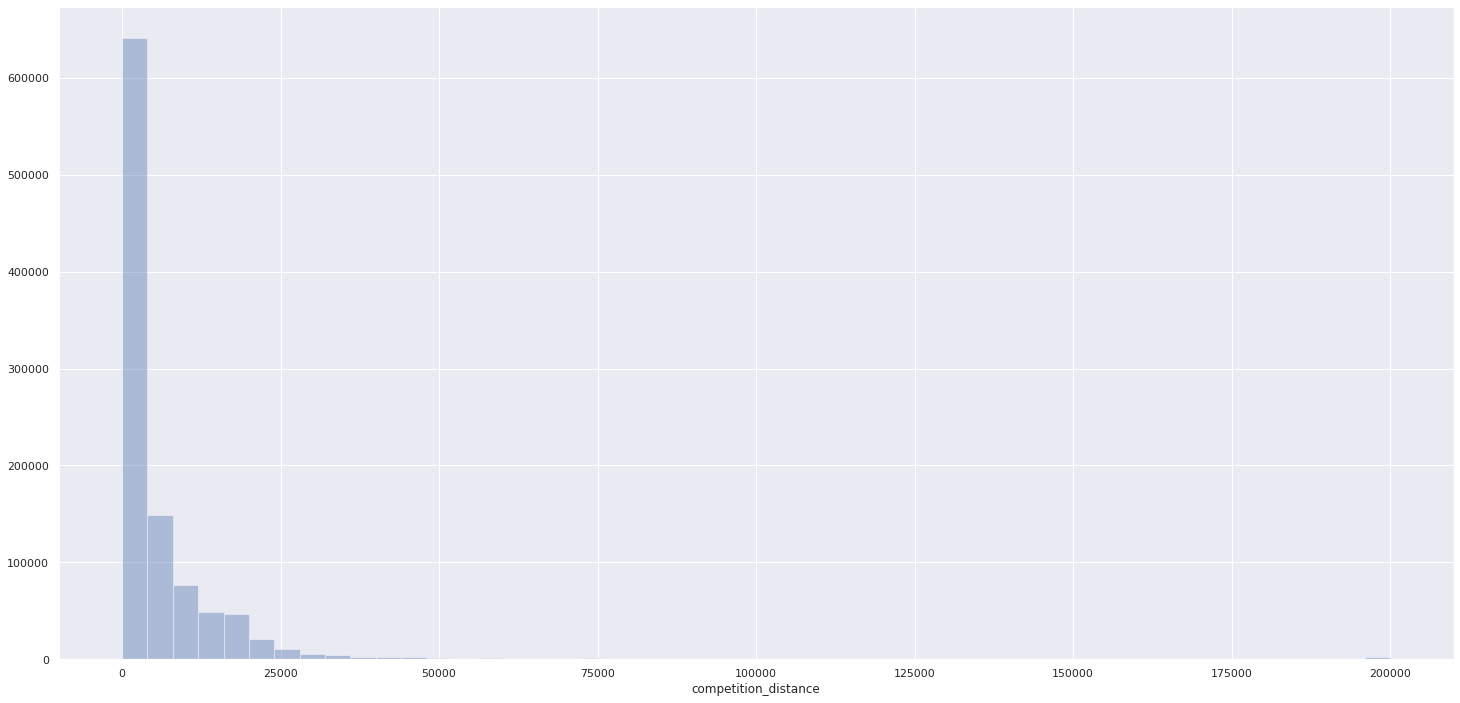

In [18]:
sns.distplot(df1['competition_distance'], kde = False)

## 1.7.2 Categorical Attributes

In [19]:
cat_attributes.apply( lambda x: x.unique().shape ).T

,0
state_holiday,4
store_type,4
assortment,3
promo_interval,4
month_map,12


<AxesSubplot:xlabel='assortment', ylabel='sales'>

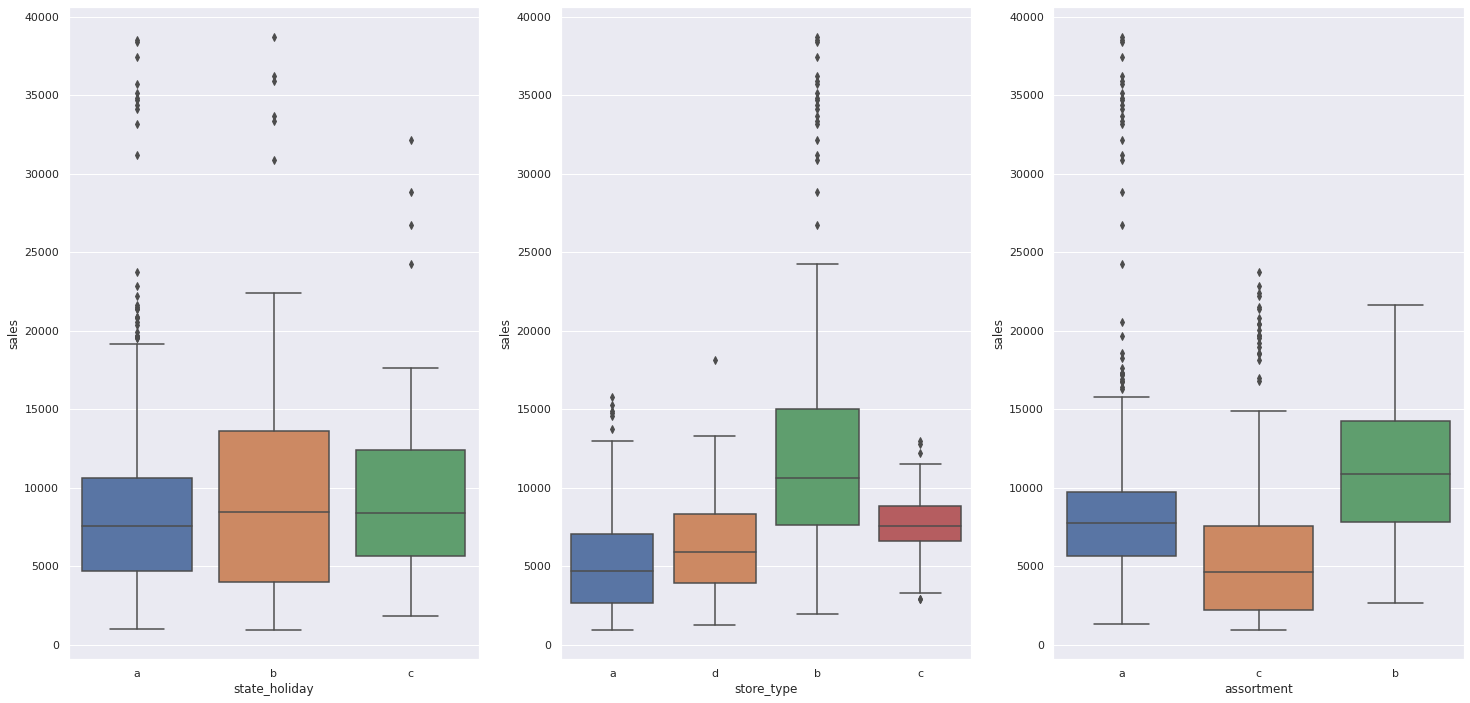

In [20]:
aux1 = df1[(df1['state_holiday']!= '0') & ( df1['sales'] > 0)]

plt.subplot (1,3,1)
sns.boxplot( x= 'state_holiday',y= 'sales', data= aux1)

plt.subplot (1,3,2)
sns.boxplot( x= 'store_type',y= 'sales', data= aux1)

plt.subplot (1,3,3)
sns.boxplot( x= 'assortment',y= 'sales', data= aux1)



# 2.0 FEATURES ENGINEERING

In [21]:
df2 = df1.copy()

## 2.1 Mind Map Hypothesis

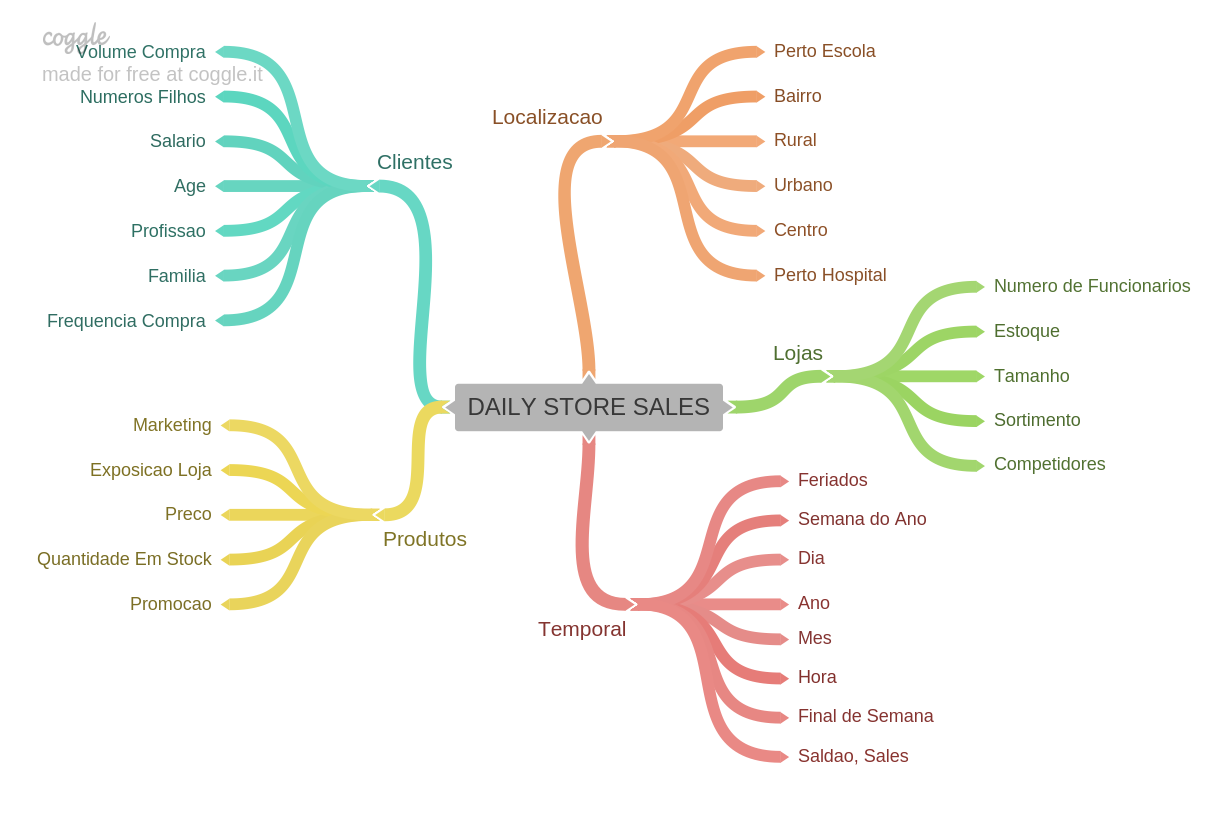

In [22]:
Image('/home/samuel/repos/DataScience_em_Producao/img/MindMapHypothesis.png')

## 2.2 Creating Hypothesis

### 2.2.1 Store Hypothesis



**1.** The highier employee number, the highier sales.

**2.** The bigger stock, the highier sales.

**3.** The bigger shop, the highier sales.

**4.** The bigger assortment, the highier sales.

**5.** The highier competitor number, the lower sales.

**6.** The longer competition, the highier sales.


### 2.2.2 Product Hypothesis

**1.** The highier Marketing budget, the highier sales.

**2.** The highier exposure, the highier sales.

**3.** The lower price, the highier sales.

**5.** The bigger dicount, the highier sales.

**6.** The longer promotion, the highier sales.

**7.** The more promotion days, the highier sales.

**8.** The more sequential promotions, the highier sales.

### 2.2.3 Time Hypothesis



**1.** Stores open on Christmas should have highier sales.

**2.** Sales should encrease over years.

**3.** Sales should encrease after halfyear.

**4.** Sales should encrease after the 10th days of every month.

**5.** Sales should decrease on weekends.

**6.** Sales should decrease on school holidays.


## 2.3 Hypothesis Final List



**1.** The bigger assortment, the highier sales.

**2.** The highier competitor number, the lower sales.

**3.** The longer competition, the highier sales.

**4.** The longer promotion, the highier sales.

**5.** The more promotion days, the highier sales.

**6.** The more sequential promotions, the highier sales.

**7.** Stores open on Christmas should have highier sales.

**8.** Sales should encrease over years.

**9.** Sales should encrease after halfyear.

**10.** Sales should encrease after the 10th days of every month.

**11.** Sales should decrease on weekends.

**12.** Sales should decrease on school holidays.


## 2.4 Features Engineering

In [23]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W')

#competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year= x['competition_open_since_year'], month= x['competition_open_since_month'], day=1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply( lambda x: x.days).astype( int ) 


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype (str) + '-' + df2['promo2_since_week'].astype (str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta( days =7))

df2['promo_time_week'] = ((df2['date']- df2['promo_since'])/7).apply(lambda x: x.days ).astype (int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 VARIABLES FILTERING

In [25]:
df3 = df2.copy()

## 3.1  Row Filtering

In [26]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0 )]

## 3.2 Columns Selection

In [27]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis =1 )

In [28]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0 EXPLORATORY DATA ANALYSIS

In [29]:
df4 = df3.copy()

In [30]:
df4[df4['state_holiday'] == 'regular_day'].head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1 Univariate Analysis

### 4.1.1 Response Variable

/home/samuel/.pyenv/versions/DataScienceEmProducao/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

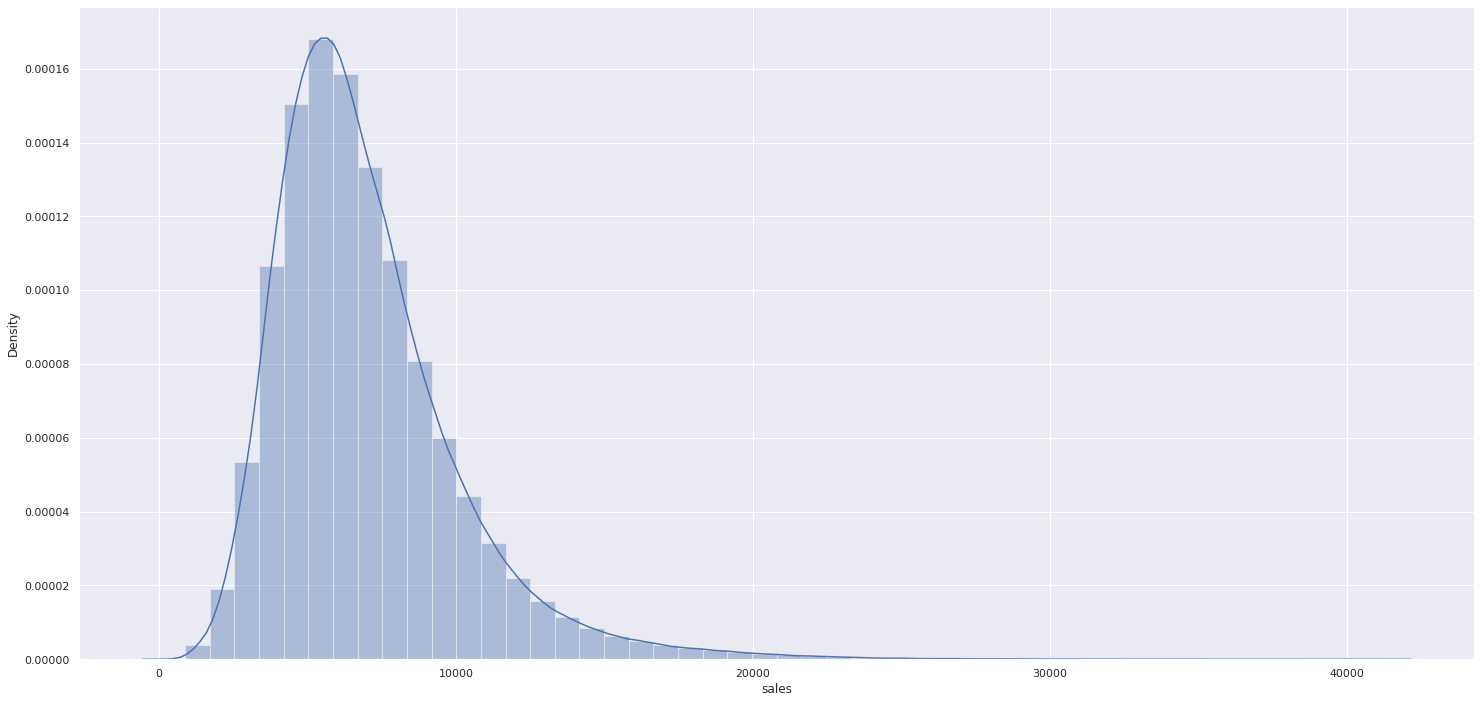

In [31]:
sns.distplot(df4['sales'])

### 4.1.2 Numerical Variable

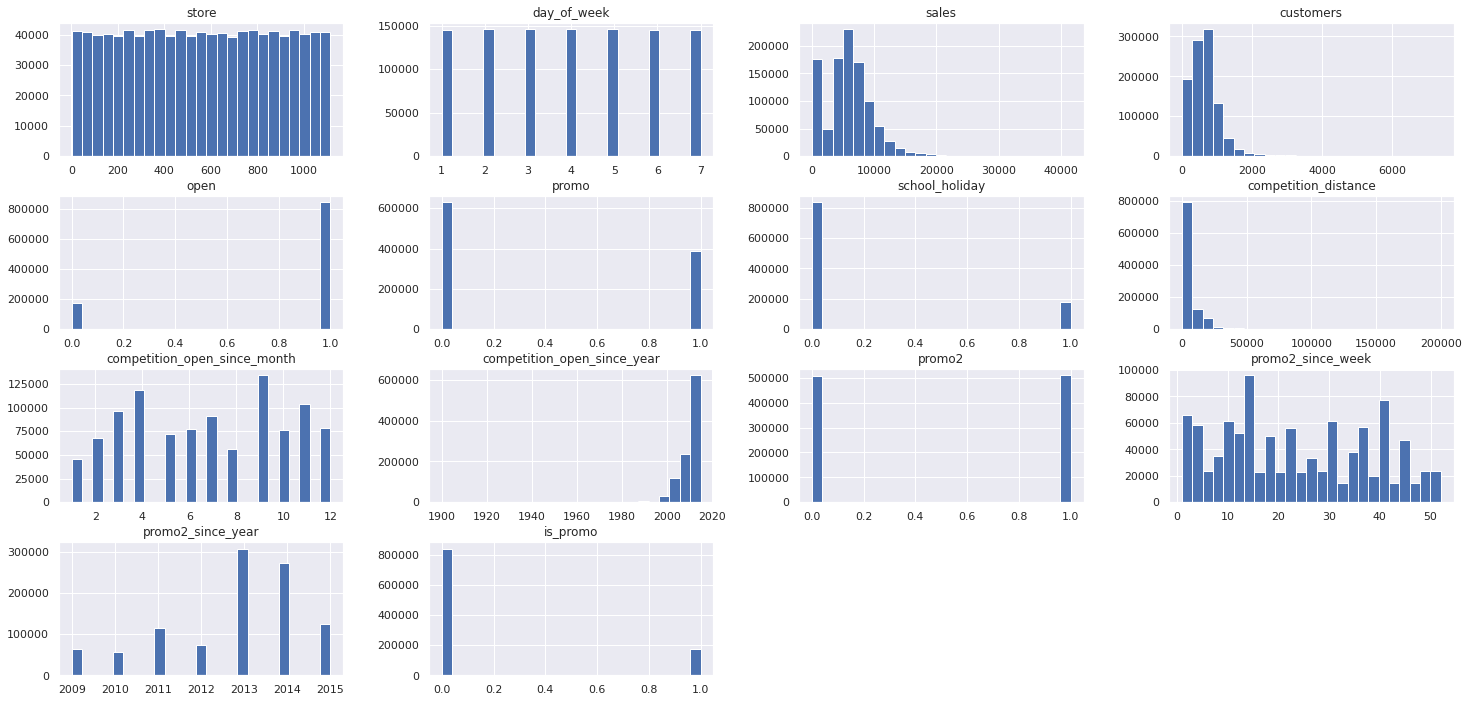

In [32]:
num_attributes.hist(bins = 25);

### 4.1.3 Categorical Variable

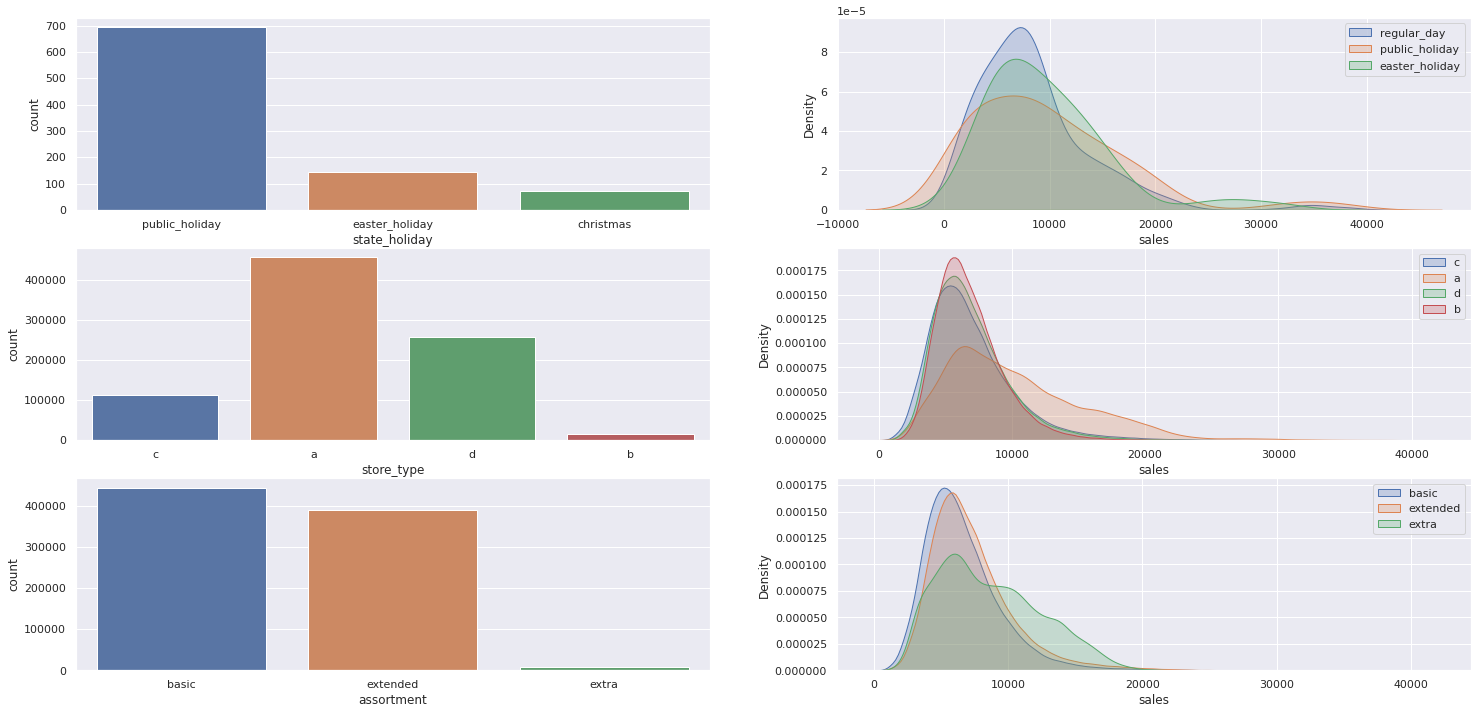

In [33]:
# state holiday

plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x = 'state_holiday', data = a )

plt.subplot(3,2,2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], shade = True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], shade = True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], shade = True)
plt.legend(df4['state_holiday'].drop_duplicates());

# store type

plt.subplot(3,2,3)
sns.countplot( x = 'store_type', data = df4 )

plt.subplot(3,2,4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], shade = True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], shade = True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], shade = True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], shade = True)
plt.legend(df4['store_type'].drop_duplicates());


# assortment

plt.subplot(3,2,5)
sns.countplot( x = 'assortment', data = df4 )

plt.subplot(3,2,6)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], shade = True)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], shade = True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], shade = True)
plt.legend(df4['assortment'].drop_duplicates());


## 4.2 Bivariate Analysis

### H1. The bigger assortment, the highier sales.

**FALSE** The bigger assortment, the **lower** sales


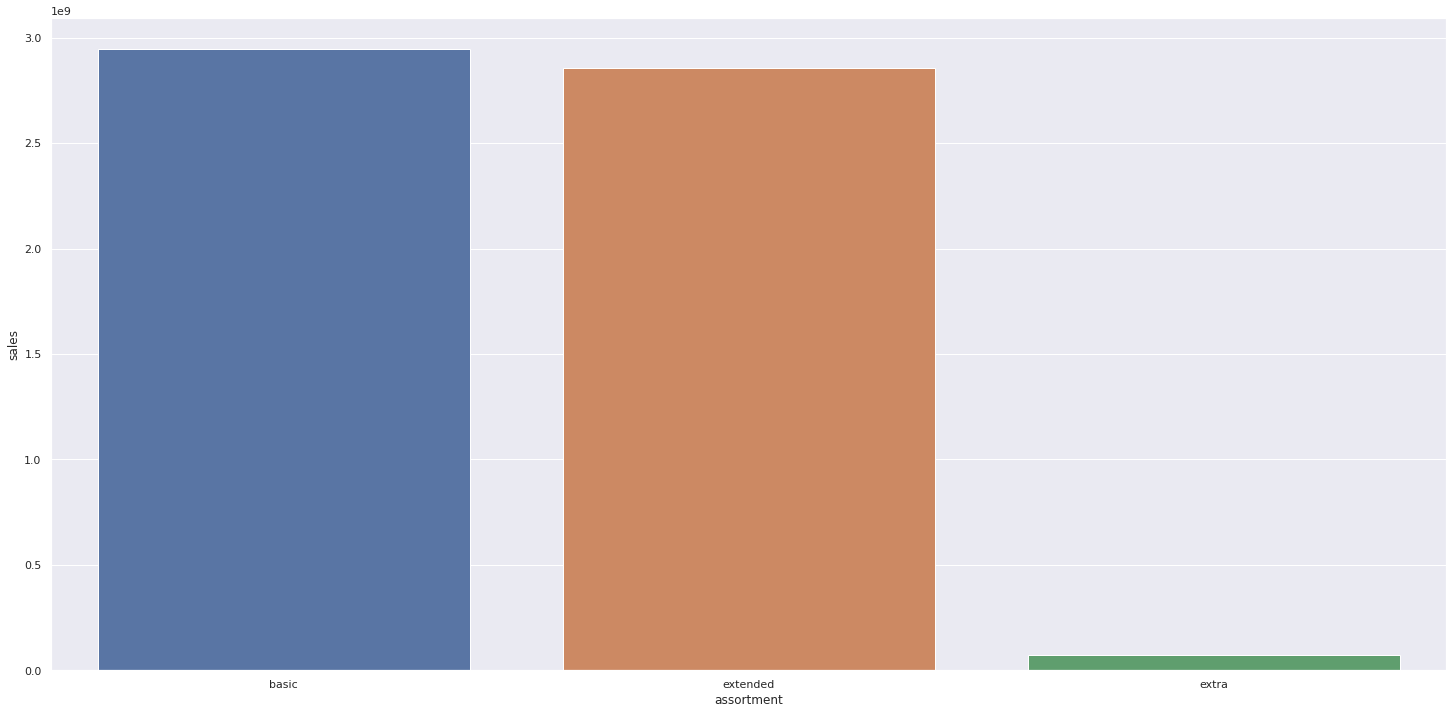

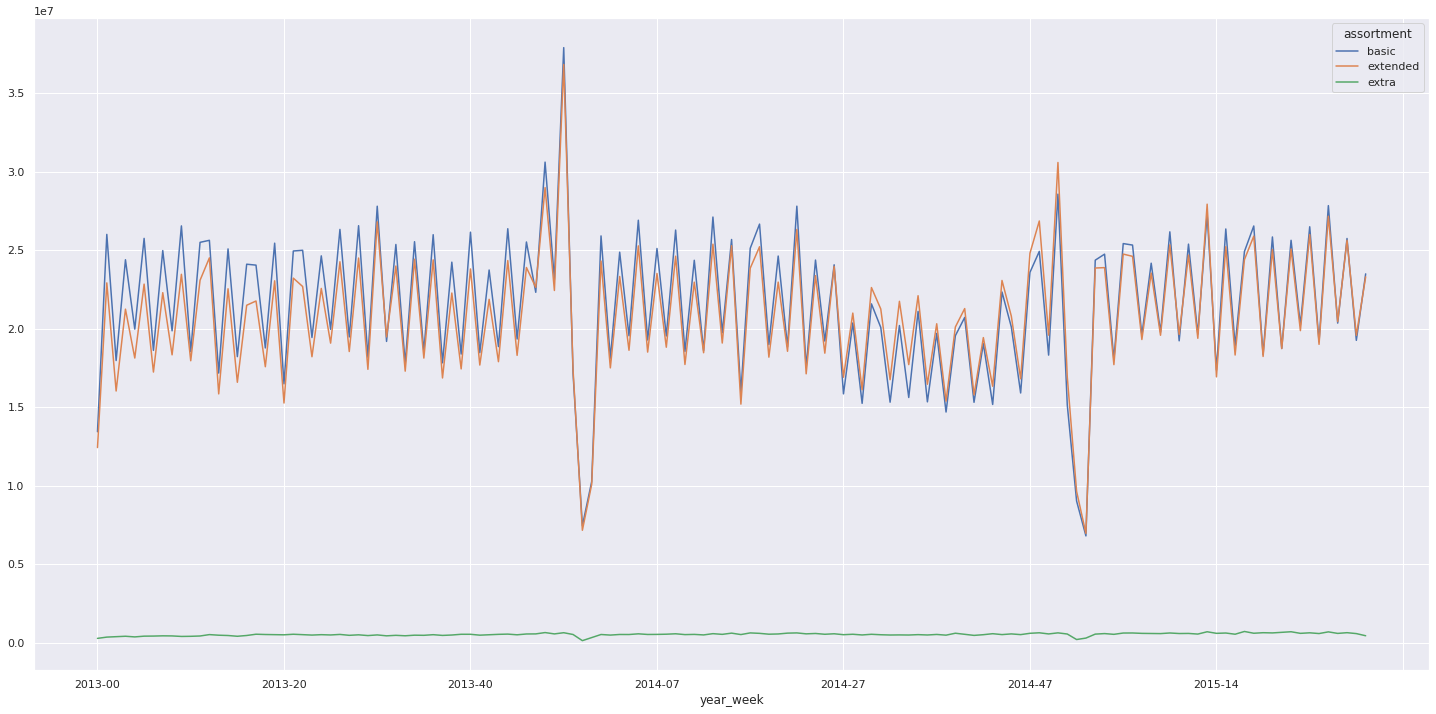

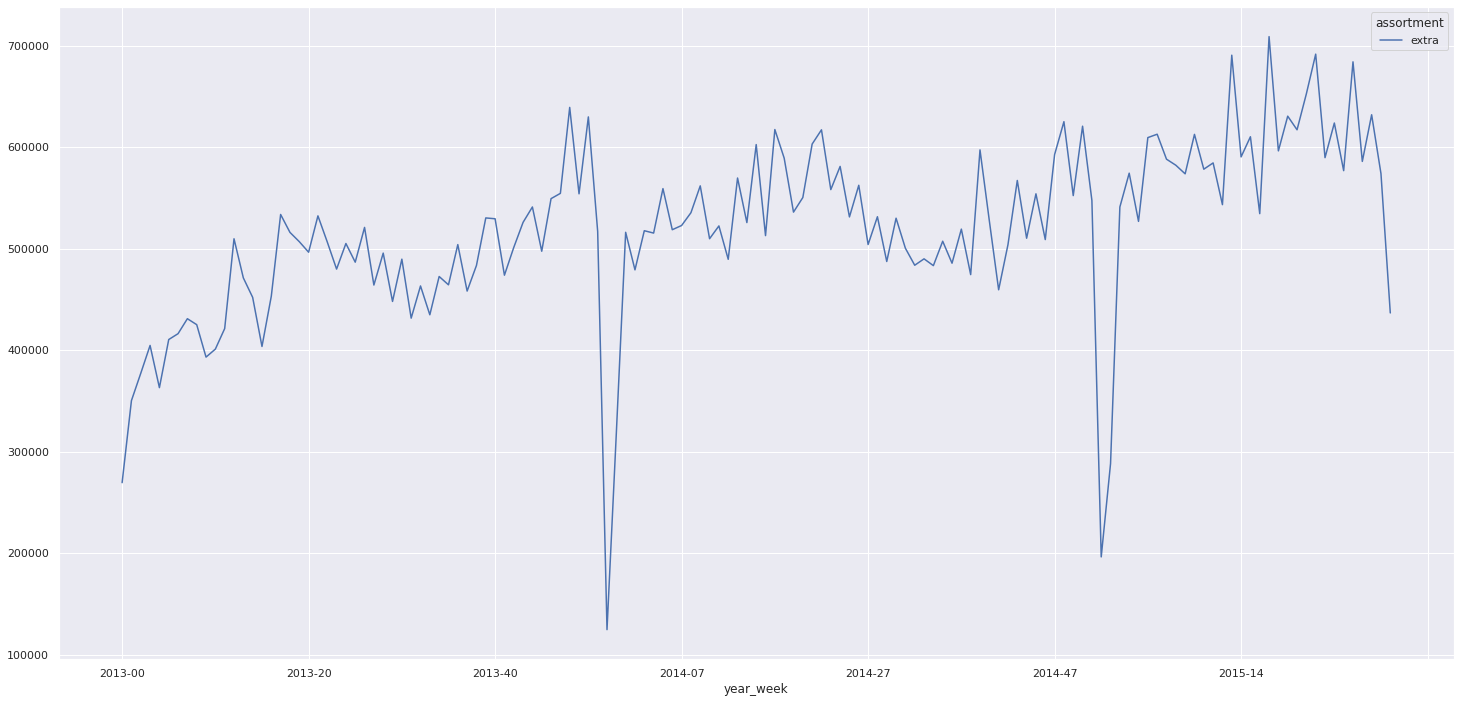

In [34]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1);

aux2 = df4[[ 'year_week', 'assortment','sales']].groupby( ['year_week', 'assortment'] ).sum().reset_index()
aux2.pivot ( index= 'year_week', columns= 'assortment' , values= 'sales' ).plot();


aux3 = aux2[aux2[ 'assortment'] == 'extra']
aux3.pivot ( index= 'year_week', columns= 'assortment' , values= 'sales' ).plot();

### H2. The highier competitor number, the lower sales.
**FALSE** The highier competitor number, the **highier** sales

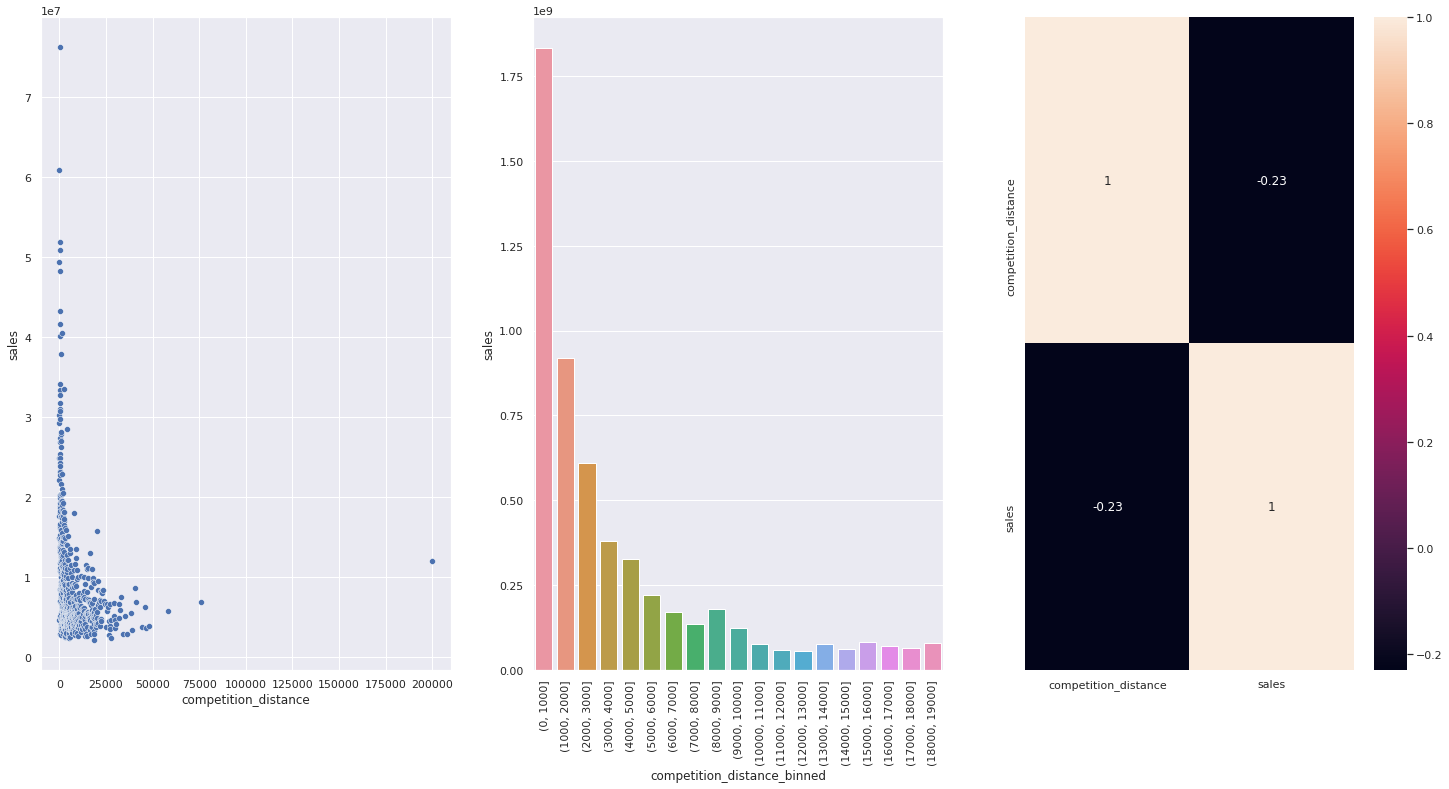

In [35]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot( 1,3,1)
sns.scatterplot(x= 'competition_distance' , y = 'sales', data = aux1);

plt.subplot( 1,3,2)
bins = list( np.arange( 0, 20000, 1000))
aux1[ 'competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks( rotation = 90)

plt.subplot( 1,3,3)
sns.heatmap( aux1.corr( method = 'pearson'), annot = True);

### H3. The longer competition, the highier sales.
**FALSE** The longer competition, the **lower** sales

<AxesSubplot:>

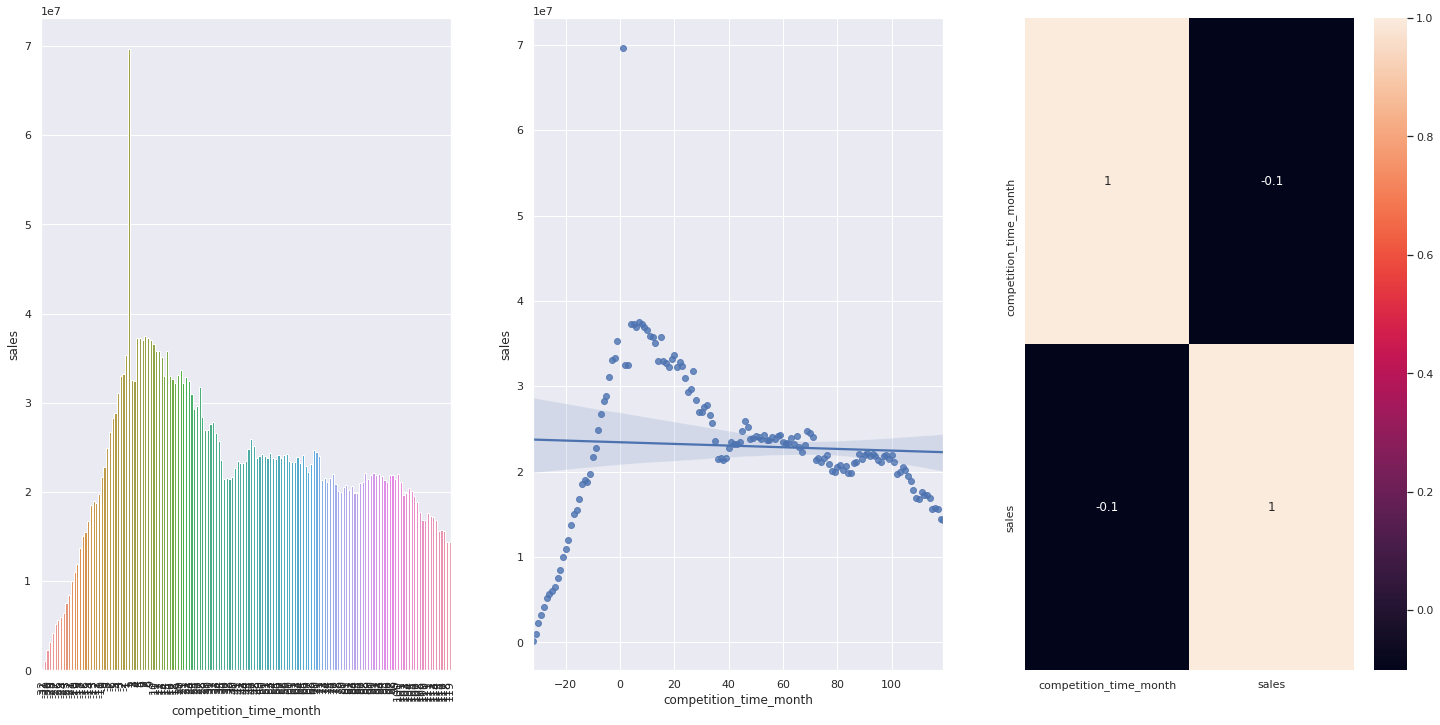

In [36]:
plt.subplot( 1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & ( aux1['competition_time_month'] != 0 )]
sns.barplot( x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks( rotation =90);

plt.subplot( 1,3,2)
sns.regplot( x = 'competition_time_month', y = 'sales', data = aux2);

plt.subplot(1,3,3)
sns.heatmap( aux1.corr(method = 'pearson'), annot = True)

### H4. The longer promotion, the highier sales.
**FALSE** Sales decrease after a while of promo period

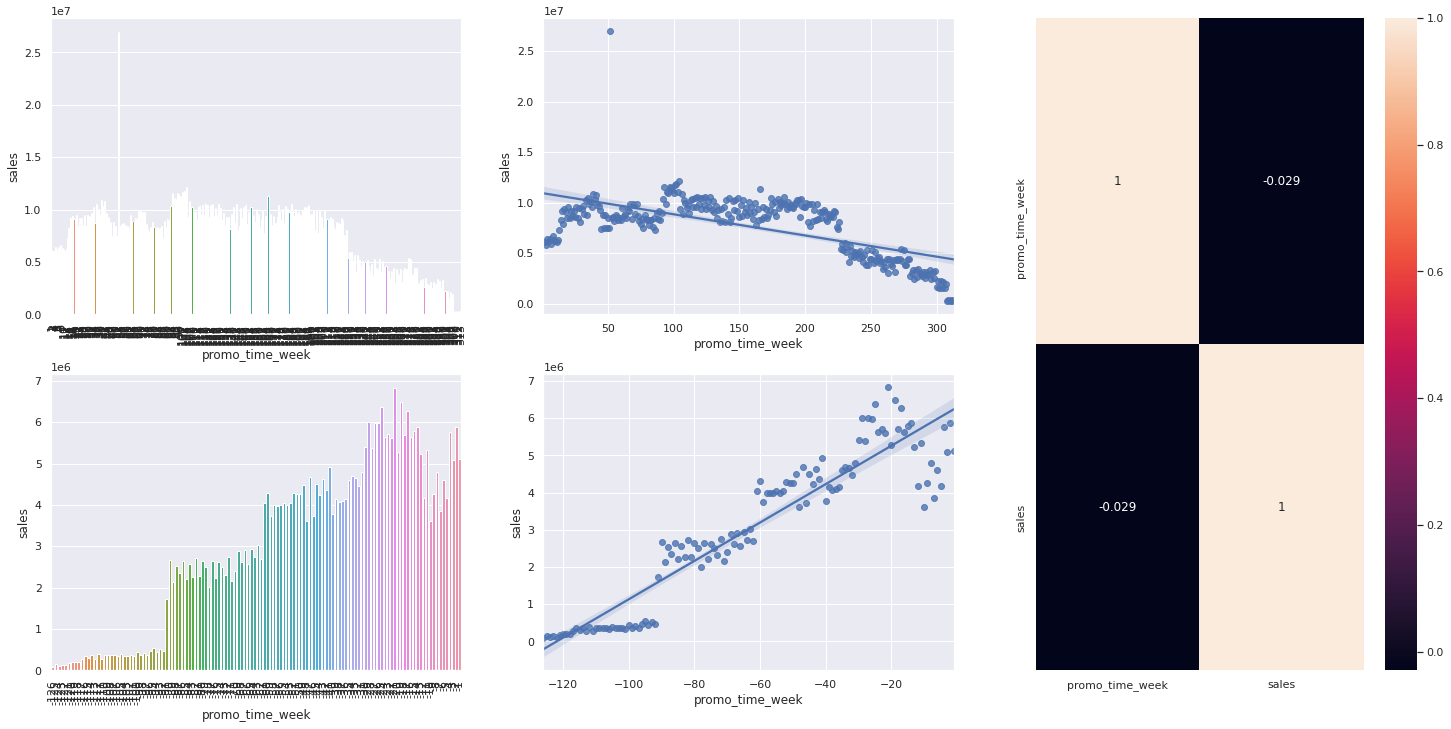

In [37]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()

grid = GridSpec( 2, 3)

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0]  # promo_2
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks( rotation = 90);

plt.subplot(  grid[0,1] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0]  # regular promo
sns.barplot( x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks( rotation = 90);

plt.subplot( grid[1,1] )
sns.regplot( x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method = 'pearson'), annot = True);

### <s>H5. The more promotion days, the highier sales.</s>

### H6. The more sequential promotions, the highier sales. 
**FALSE** The more sequential promotions, the **lower** sales

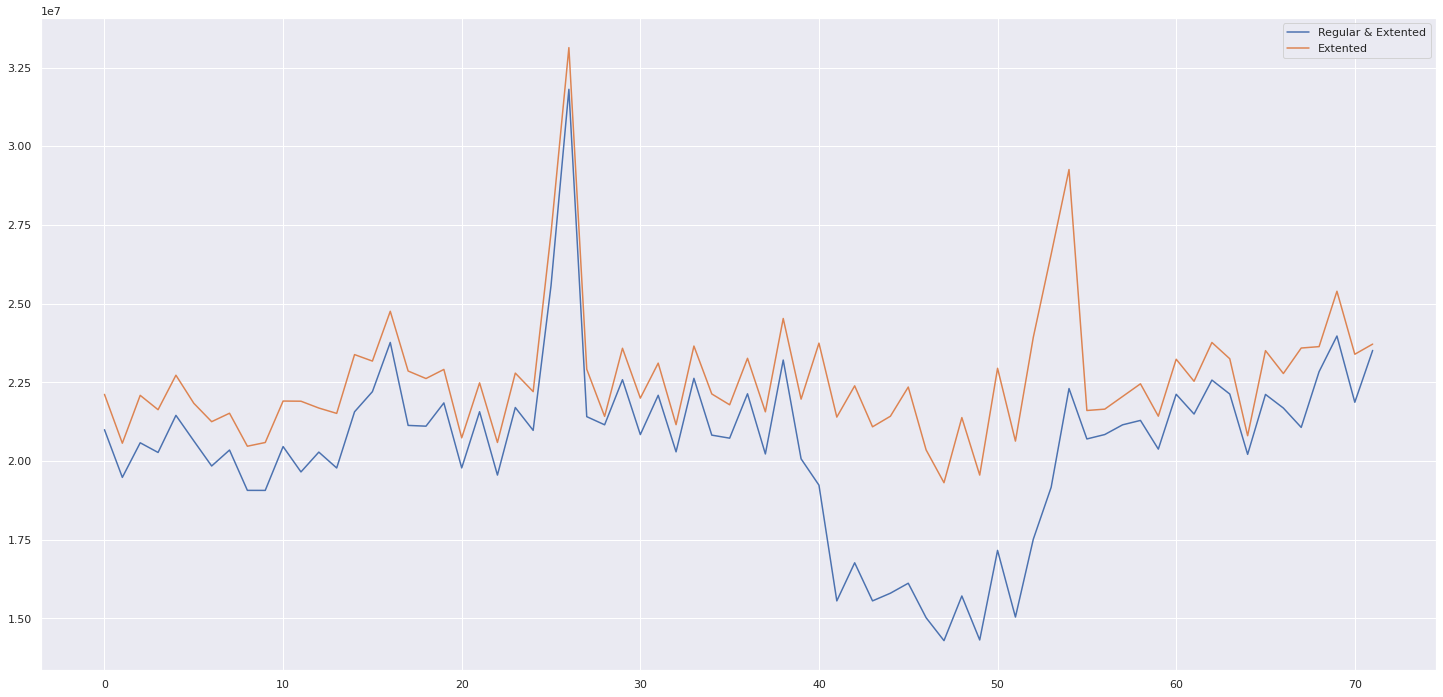

In [38]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week').sum().reset_index()
aux2.plot( ax = ax)

ax.legend( labels = ['Regular & Extented', 'Extented'])

### H7. Stores open on Christmas should have highier sales.
**FALSE** Stores open on Christmas sell less than other holidays

<AxesSubplot:xlabel='year', ylabel='sales'>

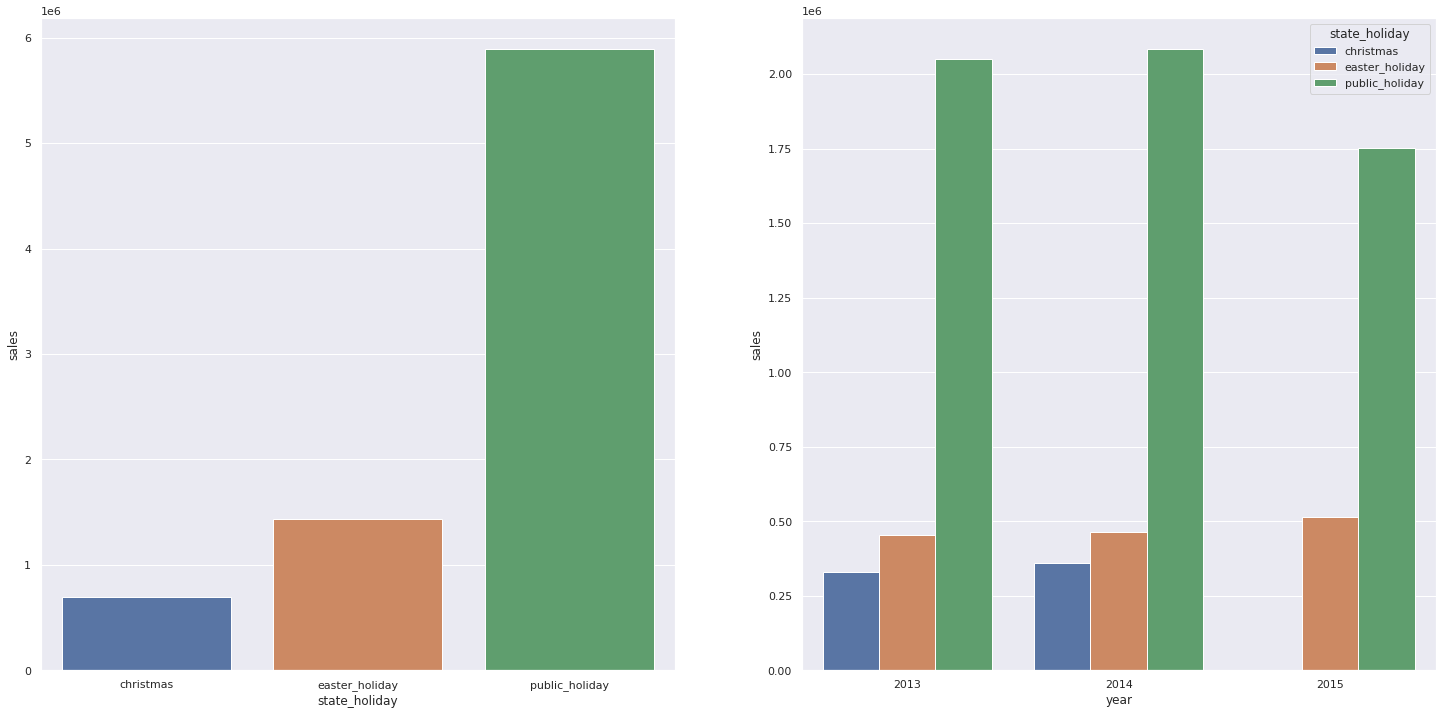

In [39]:
aux = df4[ df4['state_holiday'] != 'regular_day']

plt.subplot( 1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot( x= 'state_holiday', y = 'sales', data = aux1);

plt.subplot( 1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday']).sum().reset_index()
sns.barplot( x = 'year', y = 'sales', hue = 'state_holiday', data = aux2)

### H8. Sales should encrease over years.
**FALSE** Sales is decreasing over years

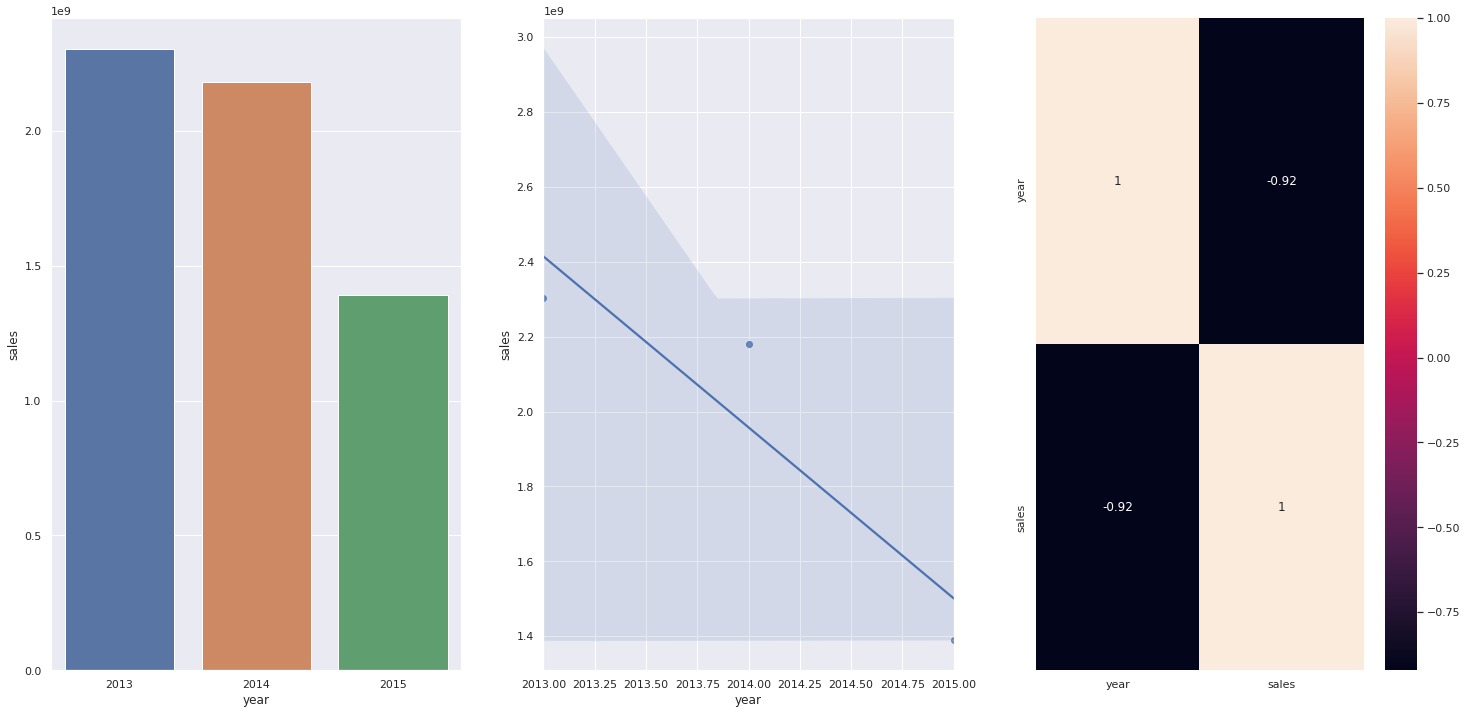

In [40]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot( 1,3,1)
sns.barplot( x= 'year', y = 'sales', data = aux1);

plt.subplot( 1,3,2)
sns.regplot( x= 'year', y = 'sales', data = aux1);

plt.subplot( 1,3,3)
sns.heatmap( aux1.corr( method = 'pearson'), annot = True);

### H9. Sales should encrease after halfyear.
**FALSE** Sales decrease after halfyear

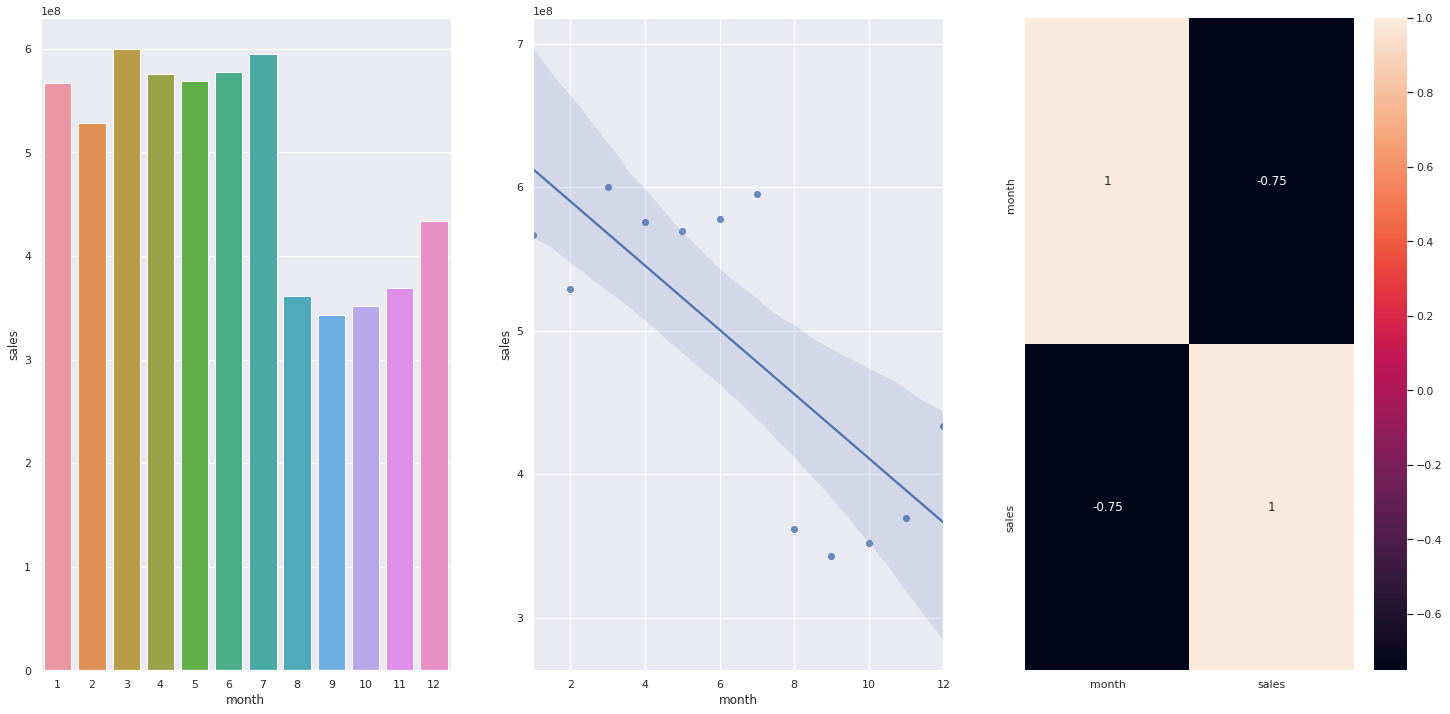

In [41]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot( 1,3,1)
sns.barplot( x= 'month', y = 'sales', data = aux1);

plt.subplot( 1,3,2)
sns.regplot( x= 'month', y = 'sales', data = aux1);

plt.subplot( 1,3,3)
sns.heatmap( aux1.corr( method = 'pearson'), annot = True);

### H10. Sales should encrease after the 10th day of every month.
**TRUE** Sales encrease after the 10th day

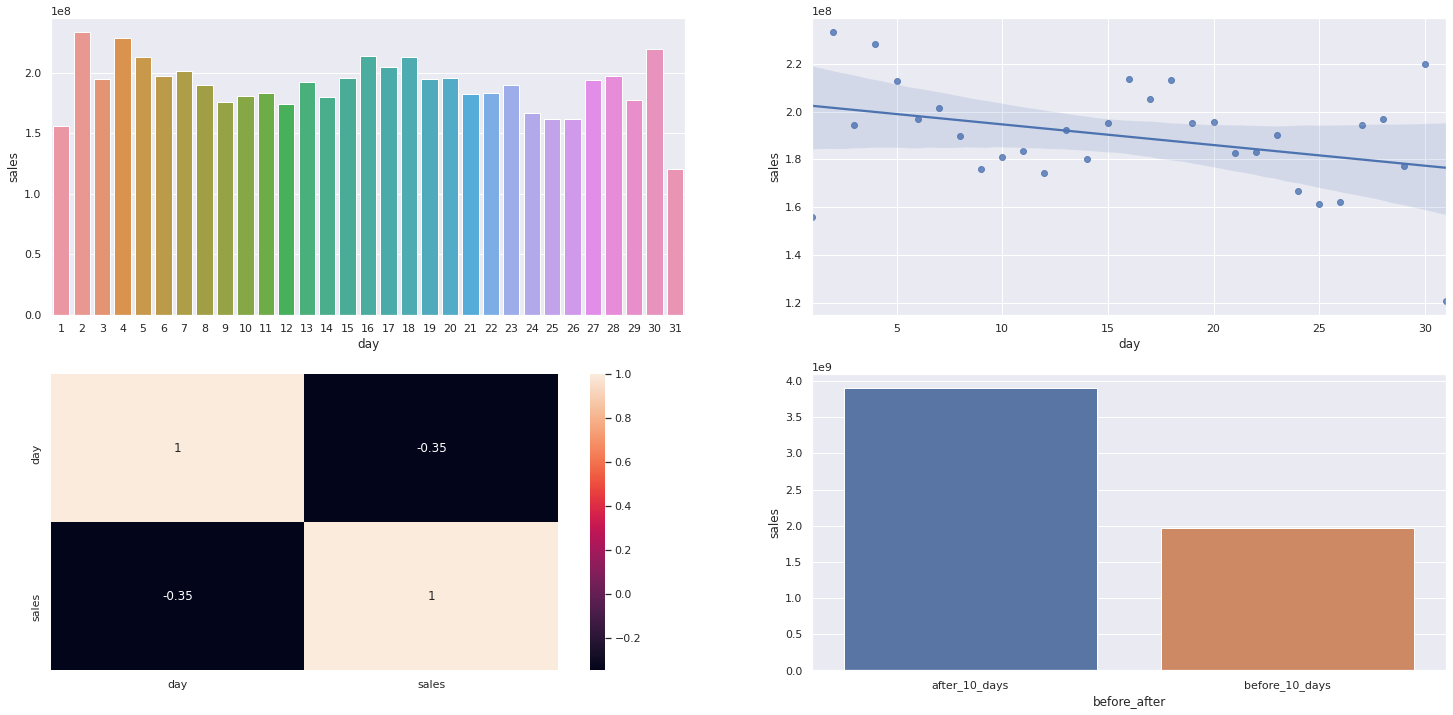

In [42]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot( 2,2,1)
sns.barplot( x= 'day', y = 'sales', data = aux1);

plt.subplot( 2,2,2)
sns.regplot( x= 'day', y = 'sales', data = aux1);

plt.subplot( 2,2,3)
sns.heatmap( aux1.corr( method = 'pearson'), annot = True);

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot( 2,2,4)
sns.barplot( x = 'before_after', y = 'sales', data = aux2);

### H11. Sales should decrease on weekends.
**TRUE** Sales decrease on weekends

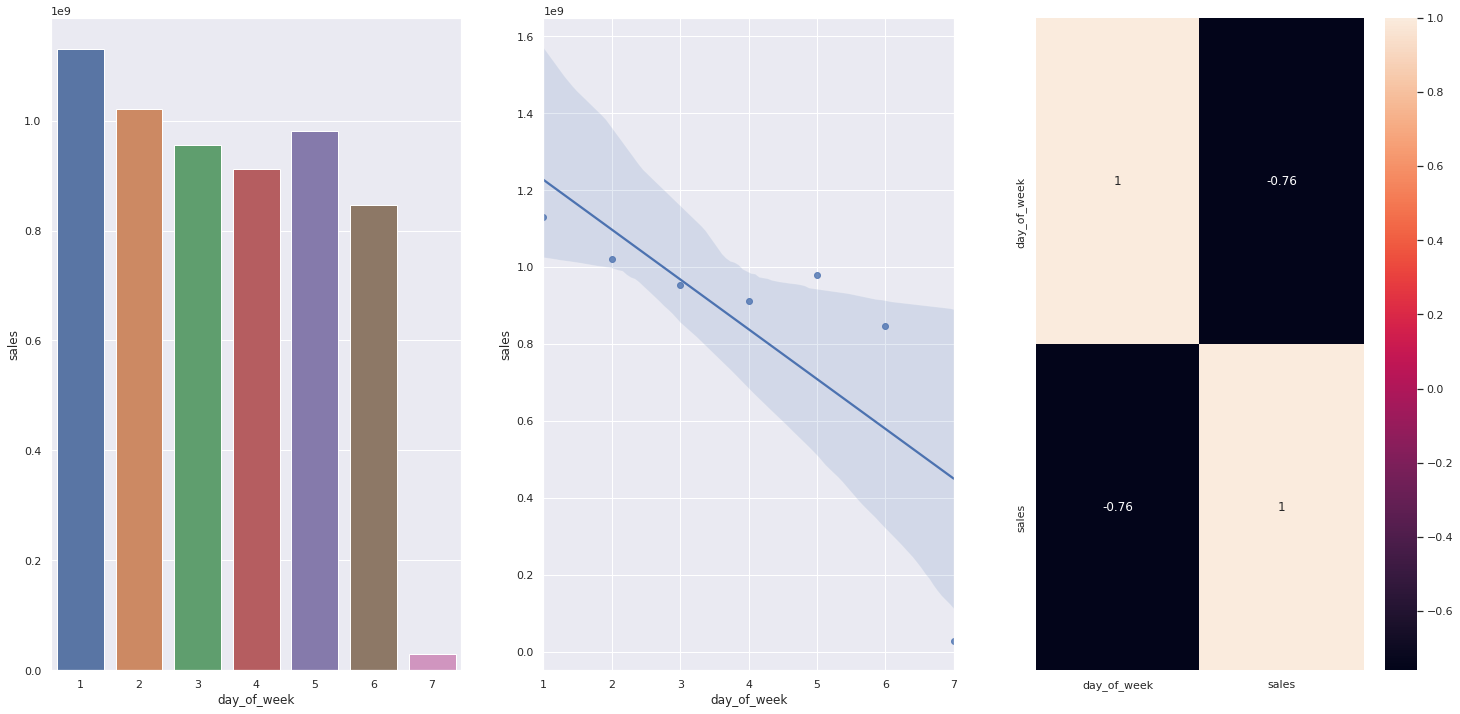

In [43]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot( 1,3,1)
sns.barplot( x= 'day_of_week', y = 'sales', data = aux1);

plt.subplot( 1,3,2)
sns.regplot( x= 'day_of_week', y = 'sales', data = aux1);

plt.subplot( 1,3,3)
sns.heatmap( aux1.corr( method = 'pearson'), annot = True);

### H12. Sales should decrease on school holidays.
**TRUE** Sales decrease on school holidays 

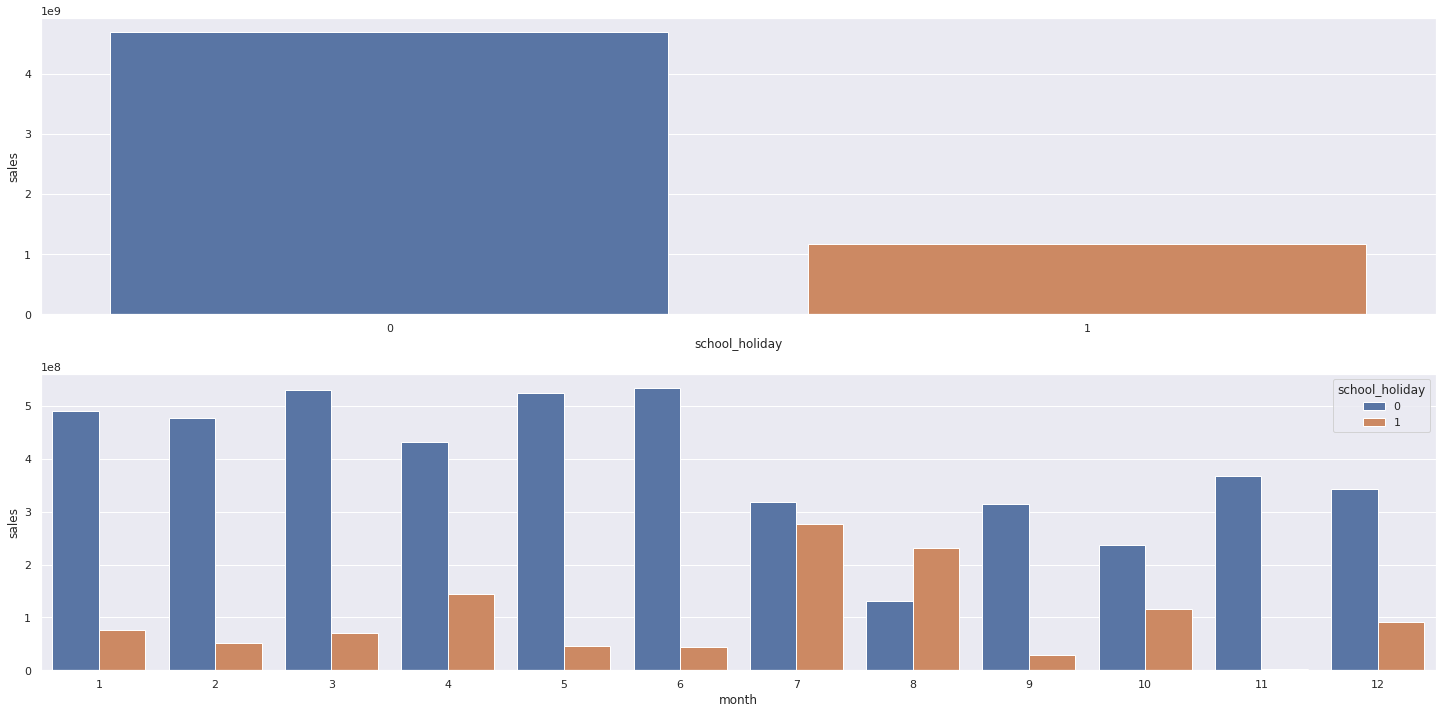

In [44]:
plt.subplot( 2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot( x= 'school_holiday', y = 'sales', data = aux1);



plt.subplot( 2,1,2)
aux2 = df4[['month','school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot( x= 'month', y = 'sales', hue = 'school_holiday', data = aux2);




### 4.2.1 Hypostesis Summary

In [45]:
from tabulate import tabulate

In [46]:
tab = [['Hypotesis', 'Conclution', 'Correlation'],
       ['H1','False','Low'],
       ['H2','False','Medium'],
       ['H3','False','Medium'],
       ['H4','False','Low'],
       ['H5','-','-'],
       ['H6','False','Low'],
       ['H7','False','Medium'],
       ['H8','False','High'],
       ['H9','False','High'],
       ['H10','True','High'],
       ['H11','True','High'],
       ['H12','True','ow'],
      ]

print( tabulate( tab, headers = 'firstrow'))

Hypotesis    Conclution    Correlation
-----------  ------------  -------------
H1           False         Low
H2           False         Medium
H3           False         Medium
H4           False         Low
H5           -             -
H6           False         Low
H7           False         Medium
H8           False         High
H9           False         High
H10          True          High
H11          True          High
H12          True          ow


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

<AxesSubplot:>

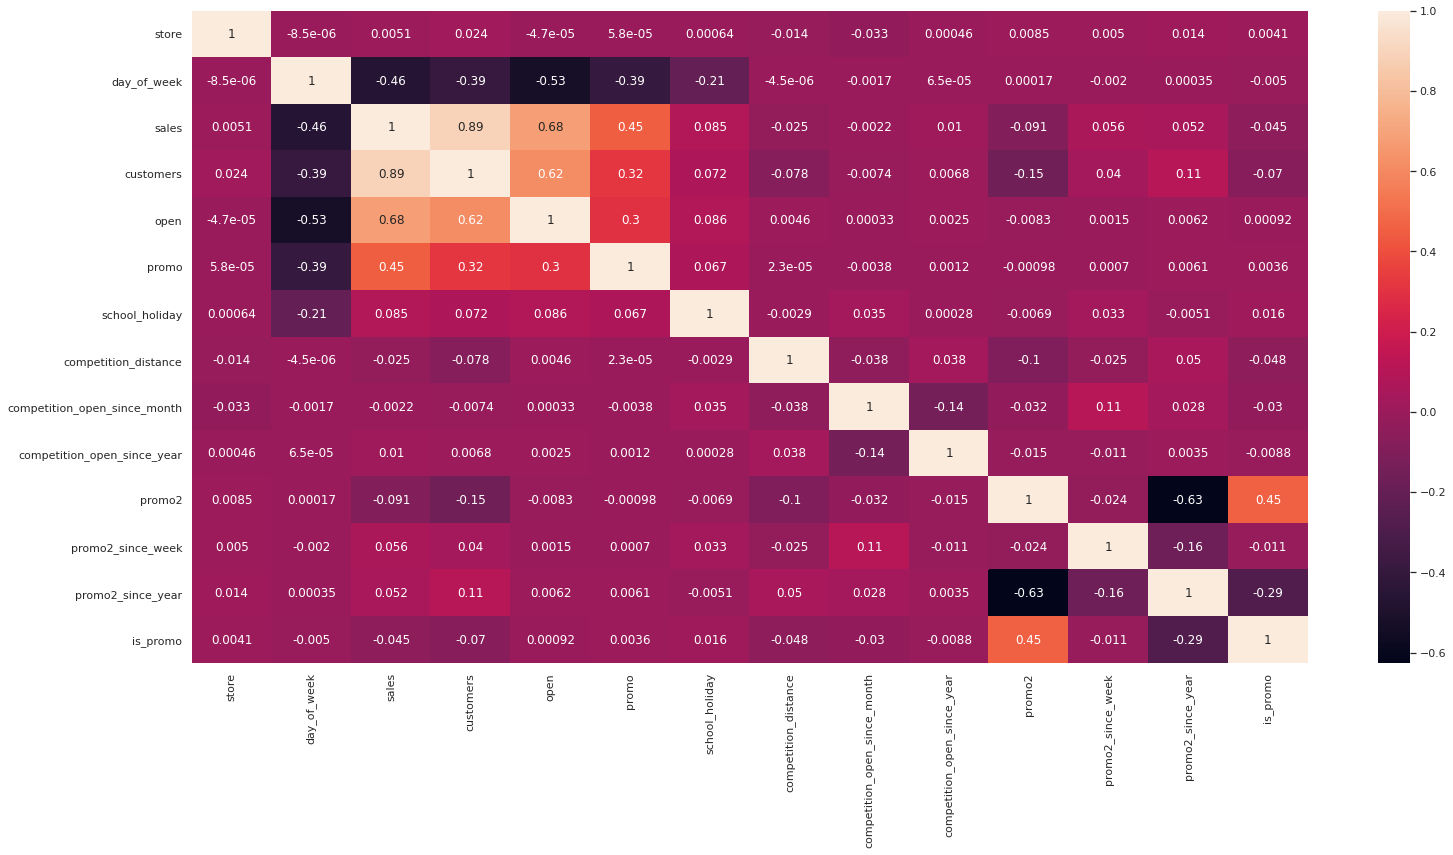

In [47]:
correlation =num_attributes.corr( method ='pearson')
sns.heatmap( correlation, annot =True)

### 4.3.2 Categorical Attributes

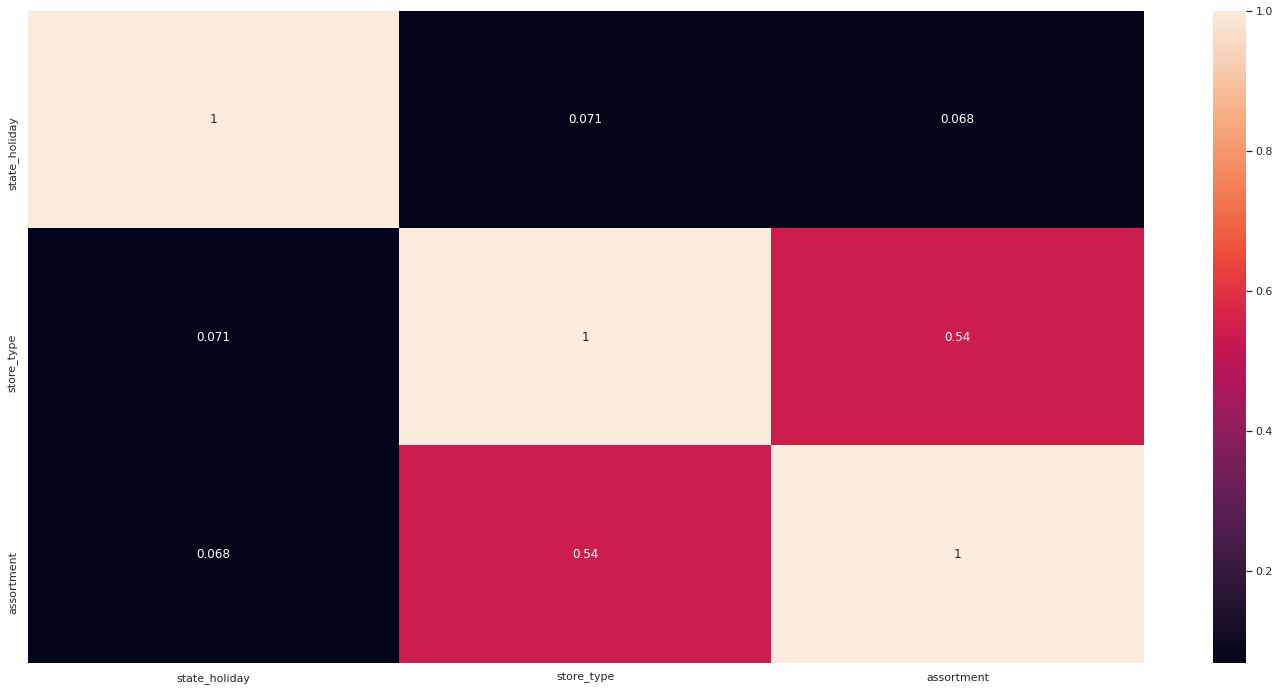

In [48]:
# only categorical data
a = df4.select_dtypes(  include = 'object')

# calculate cramer_v
a1 = cramer_v( a['state_holiday'], a['state_holiday'])
a2 = cramer_v( a['state_holiday'], a['store_type'])
a3 = cramer_v( a['state_holiday'], a['assortment'])

a4 = cramer_v( a['store_type'], a['state_holiday'])
a5 = cramer_v( a['store_type'], a['store_type'])
a6 = cramer_v( a['store_type'], a['assortment'])

a7 = cramer_v( a['assortment'], a['state_holiday'])
a8 = cramer_v( a['assortment'], a['store_type'])
a9 = cramer_v( a['assortment'], a['assortment'])


# final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
               'store_type': [a4, a5, a6],
               'assortment': [a7, a8, a9] })

d = d.set_index( d.columns)


# graphical
sns.heatmap (d, annot = True);

# 5.0 DATA PREPARATION

In [49]:
df5 = df4.copy()

## 5.1 Normalization

There is no Normal distribution as illustrated on **section 4.1.2**.

## 5.2 Rescaling

In [50]:
rs = RobustScaler()
mms = MinMaxScaler()


# competition distance
df5['competition_distance'] = rs.fit_transform( df5[[ 'competition_distance']].values )


# competition time month
df5['competition_time_month'] = rs.fit_transform( df5[[ 'competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

## 5.3 Nature Transfoming

### 5.3.1 Encoding

In [51]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns = ['state_holiday'] )

# store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2 Response Variable Transformation

In [52]:
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3 Nature Transformation

In [53]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * (2 * np.pi/7) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * (2 * np.pi/7) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * (2 * np.pi/12) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * (2 * np.pi/12) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * (2 * np.pi/30) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * (2 * np.pi/30) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * (2 * np.pi/52) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * (2 * np.pi/52) ) )



In [54]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 FEATURE SELECTION

In [55]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [56]:
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [57]:
cols_drop = ['week_of_year', 'day_of_week', 'month','day','promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1)

In [58]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [59]:
# training dataset
X_train = df6[ df6['date'] < '2015-06-19' ]
y_train = X_train['sales']

# test dataset
X_test = df6[ df6['date'] >= '2015-06-19' ]
y_test = X_test['sales']



print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [60]:
# training and test dataset for Boruta
#X_train_n = X_train.drop( ['sales','date'], axis=1).values
#y_train_n = y_train.values.ravel()


# define Randon Forest Regressor
#rf = RandomForestRegressor( n_jobs=-1)


# define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( X_train_n, y_train_n)


### 6.2.1 Best Features from Boruta

In [61]:
#cols_selected = boruta.support_.tolist()

# best features 
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d( X_train_fs.columns, cols_selected_boruta ))

## 6.3 Manual Feature Selection

In [62]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin']


# columns to add

feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0 MACHINE LEARNING MODELLING

In [63]:
x_train = X_train[ cols_selected_boruta]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1 Average Model

In [64]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1 [[ 'store', 'sales']].groupby( 'store').mean().reset_index().rename( columns= { 'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how ='left', on = 'store')
yhat_baseline = aux1 ['predictions']


# performance
baseline_result = ml_error( 'Avarage Model', np.expm1( y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [65]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr =  lr.predict( x_test )

#performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1( yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [66]:
lr_result_cv = cross_validation( x_training, 5, 'Linear Regression', lr, verbose= False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [67]:
# model
lrr = Lasso( alpha =0.01).fit( x_train, y_train )

# prediction
yhat_lrr =  lrr.predict( x_test )

#performance
lrr_result = ml_error( 'Linear Regression Regularized', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized,1891.704881,0.289106,2744.451737


### 7.3.1 Linear Regression Regularized Model - Lasso - Cross Validation

In [68]:
lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose= False )
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Model

In [69]:
# model
rf = RandomForestRegressor( n_estimators = 100, n_jobs = -1, random_state = 42).fit( x_train, y_train )

# prediction
yhat_rf =  rf.predict( x_test )

#performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1( yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.967698,0.099976,1011.75927


### 7.4.1 Random Forest Model - Cross Validation

In [ ]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf, verbose= True )
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


## 7.5 XGBoost Regressor Model

In [ ]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.1,
                             max_depth = 10,
                             subsample = 0.7,).fit( x_train, y_train )

# prediction
yhat_xgb =  model_xgb.predict( x_test )

#performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb ) )
xgb_result

### 7.5.1 XGBoost Regressor Model - Cross Validation

In [ ]:
xgb_result_cv = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose= True )
xgb_result_cv

## 7.6 Compare Model's Performance

## 7.6.1 Single Performance

In [ ]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

## 7.6.2 Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
modelling_result_cv.sort_values( 'RMSE' )